# Machine learning avec les modules Python tensorflow2/keras 

## Import the required Python modules

# A/ Convolutionnal Neuron Network (CNN)

In [73]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #suppress the numerous TensorFlow warnings

import tensorflow as tf
from tensorflow import keras

import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
from time import time

from sklearn.metrics import confusion_matrix, classification_report

print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} with keras {keras.__version__}")
print(f"numpy     : {np.__version__}")
print(f"OpenCV    : {cv2.__version__}")

# specific modules:
from utils.tools import scan_dir, plot_loss_accuracy

Python    : 3.12.3
tensorflow: 2.16.2 with keras 3.8.0
numpy     : 1.26.4
OpenCV    : 4.11.0


In [2]:
# allows to visualize the graphs directly in the cell of the notebook:
%matplotlib inline

### "LeNet5 CNN"

We build a convolutional NN similar to __LeNet5__ introduced in the research paper “Gradient-Based Learning Applied To Document Recognition” in 1998 by Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffnerfrom.
LeNet5 was originally designed for 32$\times$32 images:

![img/LeNet5.png](img/LeNet5.png)

### Extracting features from an image with a convolution filter

The convolution of an image by a filter (also called kernel, *kernel*) consists of moving a _small 2D window_ (3x3, 5x5....) over the pixels of the image and calculating each time the _contracted tensor product_ between the elements of the filter and the pixels of the image delimited by the filter window (sum of the products term by term).<br>

The animation below illustrates the convolution of a 5x5 image by a 3x3 filter without *padding* on the edges: we obtain a new, smaller image of 3x3 pixels<br>
<p style="text-align:center; font-style:italic; font-size:12px;">
     <img src="img/filter_3x3.png" width="80" style="display:inline-block;">
     <img src="img/Convolution_schematic.gif" width="300" style="display:inline-block;"><br>
     [image credit: <a href="http://deeplearning.stanford.edu/tutorial">Stanford deep learning tutorial</A>]
</p>

To maintain the size of the input image, we can use a *padding* technique to create new data on the edges of the image (by duplicating data on the edges, or adding rows and columns of 0... for example):

<p style="text-align:center; font-style:italic; font-size:12px;">
     <img src="img/padding.gif" width="350"><br>
     [image credit: <a href="https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2">Arden Dertat</a> ]
</p>

The goal of convolution is to extract features present in the source image: we speak of a “feature map” to designate the image produced by the convolution operation. The state of the art leads to using several convolutional filters to extract different characteristics: we can have up to several dozen convolutional filters in the same layer of the network which generate as many _feature maps_, hence the increase in data created by these convolution operations...

#### Examples of feature extraction with known convolutional filters ([Prewitt filter](https://fr.wikipedia.org/wiki/Filtre_de_Prewitt)):

As an example, the figure below shows the *feature maps* obtained by convolving a MNIST image (a digit 7) with 4 3x3 filters well known in image processing (Prewitt filters for contour extraction) :

<p style="text-align:center; font-style:italic; font-size:12px;">
     <img src="img/7_mnist_4_filtres.png" width="500"><br>
     [image credit: JLC]
</p>

We see that these filters act as edge detection filters: in the output images, the whitest pixels constitute what the filters detected:
- filters (a) and (c) detect lower and upper horizontal contours,
- filters (b) and (d) detect right and left vertical contours.

These very simple examples allow you to understand how the extraction of *features* from an image using convolutional filtering works.

#### From the convolutional filter to the convolutional neuron layer

The integration of convolutional filtering into the structure of the neural network gives the following organization of calculations:

- Each convolutional filter has the same coefficients for the 3 colors: for the LeNet5 network for example, each of the 6 5x5x3 filters of the first layer has only 25 coefficients, identical for the colors R, G & B.

- Each unit (convolutional neuron) of a *feature map* of layer C1 receives 75 pixels (25 red pixels $R_i$, 25 green pixels $G_i$ and 25 blue pixels $B_i$) delimited by the position of the convolutional filter in the source image.

- The neuron $k$ of a *feature map* calculates an output $y_k = F_a(\sum_{i=1}^{25}{\omega_i(R_i + G_i + B_i) - b_k})$, where $ b_k$ is the bias of the neuron $k$ and $F_a$ the activation function (very often `relu`).

- for the 6 convolutional filters of layer C1, we therefore have 6 x (25 + 1) parameters, i.e. 156 unknown parameters for this layer which will be determined by training the network.

The same pattern is used in all convolutional layers.

### Reducing the amount of information with _pooling_

*pooling* aims to reduce the amount of data to be processed. As for the convolution operation, we move a filter over the elements of the *feature map* array and at each position of the filter, we calculate a number representing all the elements selected in the filter (the maximum value, or the average....). But unlike convolution, we move the filter without overlap.<br>
In the simplified example below, the *max spool* filter transforms the 8x8 matrix into a 4x4 matrix which describes "roughly" the same information but with less data:
<p style="text-align:center; font-style:italic; font-size:12px;">
     <img src="img/max_pool_2x2.png" width="350"><br>
     [image credit: JLC</a> ]
</p>

# B/ Training he CNN

In [3]:
SEED = 123
#np.random.seed(SEED)      
#tf.random.set_seed(1234)

## 3 $-$ Load the MNIST dataset (images and labels)

We use the keras `load_data` function to load the data from the MNIST 
(see [tf.keras.datasets.mnist.load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data)):<br>
- `im_train`, `lab_train` are the training images and labels,
- `im_valid`, `lab_valid` are the validation images and labels.

In [4]:
(im_train, lab_train), (im_valid, lab_valid) = keras.datasets.mnist.load_data()

Let's check the `shape` and `dtype` attributes of the numpy arrays:

In [5]:
print("im_train.shape :", im_train.shape, ", dtype:", im_train.dtype,)
print("lab_train.shape:", lab_train.shape,  ", dtype:", lab_train.dtype)
print("im_valid.shape  :", im_valid.shape,  ", dtype:", im_valid.dtype,)
print("lab_valid.shape :", lab_valid.shape,  ", dtype:", lab_valid.dtype)

im_train.shape : (60000, 28, 28) , dtype: uint8
lab_train.shape: (60000,) , dtype: uint8
im_valid.shape  : (10000, 28, 28) , dtype: uint8
lab_valid.shape : (10000,) , dtype: uint8


### Visualization of images and labels:

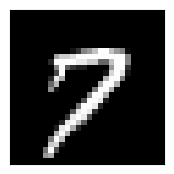

The image should show the digit 7...


In [6]:
plt.figure(figsize=(2,2))
plt.imshow(im_train[599], cmap='gray')
plt.xticks([]); plt.yticks([])
plt.show()

print(f"The image should show the digit {lab_train[599]}...")

The local module `utils.tools` defines the `plot_images` function which can be used to diplay a grid of MINIT images:

In [7]:
from utils.tools import plot_images
help(plot_images)

Help on function plot_images in module utils.tools:

plot_images(image_array: numpy.ndarray, R: int, C: int, r: int = 0, figsize: tuple = None, reverse: bool = False)
    Plot the images from image_array on a R x C grid, starting at image rank r.
    Arguments:
       image_array: an array of images
       R: the number of rows
       C: the number of columns
       r: the starting rank in the array image_array (default: 0)
       figsize: the sise of the display (default: (C//2+1, R//2+1))
       reverse: wether to reverse video the image or not (default: False)



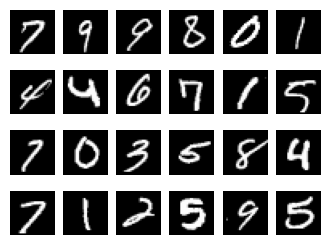

In [8]:
plot_images(im_train, 4, 6, 599)

## Split data sets

To follow the _state of the art_, we will use 3 dataset: train, validation & test.<br>
A simple way to do this is to split the current validation set in two subsets:
- a new smaller validation set,
- a test set.

This can be done easly with the function `split_train_test()` available with the module **sklearn** already imported:

In [9]:
from sklearn.model_selection import train_test_split

im_valid, im_test, lab_valid, lab_test = train_test_split(im_valid, lab_valid,
                                                          stratify=lab_valid,
                                                          test_size=0.5,
                                                          shuffle=True,
                                                          random_state=SEED)

In [84]:
im_train[0].shape, x_train[0].shape

((28, 28), (28, 28, 1))

## 3 - Pre-process input dataset

The convolutional layers of keras take by default arrays of shape `(batch_size, height, width, depth)` :
- `batch_size` : umber of images in a batch of input date,
- `height` et `width` : the size of the images in pixels,
- `depth` : color dimension (`3` for a RGB image, `1` for a grey tone image).

The shapes of the input arrays ares :

In [10]:
im_train.shape, im_valid.shape, im_test.shape

((60000, 28, 28), (5000, 28, 28), (5000, 28, 28))

we must add the dimension `depth` (value: 1 for grey tone images) after the third dimension `width`, for example using the method `reshape` of the class `ndarray`.<br>
We also normalize the input arrays so that their elements are in [0, 1]. 

In [11]:
# avec  la méthode reshape des tableaux ndarray de numpy :
x_train = im_train.reshape(im_train.shape + (1,))/255
x_valid = im_valid.reshape(im_valid.shape + (1,))/255
x_test  = im_test.reshape(im_test.shape + (1,))/255

# check:
print(f'train:  {im_train.shape} -> {x_train.shape},  min: {x_train.min()}, max: {x_train.max()}')
print(f'valid:  {im_valid.shape} -> {x_valid.shape},  min: {x_valid.min()}, max: {x_valid.max()}')
print(f'test :  {im_test.shape}  -> {x_test.shape},  min: {x_test.min()}, max: {x_test.max()}')


train:  (60000, 28, 28) -> (60000, 28, 28, 1),  min: 0.0, max: 1.0
valid:  (5000, 28, 28) -> (5000, 28, 28, 1),  min: 0.0, max: 1.0
test :  (5000, 28, 28)  -> (5000, 28, 28, 1),  min: 0.0, max: 1.0


check:

In [12]:
print(f"train: shape={x_train.shape}, min,max: ({x_train.min():f}, {x_train.max():f})")
print(f"valid: shape={x_valid.shape}, min,max: ({x_valid.min():f}, {x_valid.max():f})")
print(f"valid: shape={x_test.shape}, min,max: ({x_test.min():f}, {x_test.max():f})")

train: shape=(60000, 28, 28, 1), min,max: (0.000000, 1.000000)
valid: shape=(5000, 28, 28, 1), min,max: (0.000000, 1.000000)
valid: shape=(5000, 28, 28, 1), min,max: (0.000000, 1.000000)


### *one-hot* encoding of labels:

We use the **keras** `to_categorical` function (see [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)) to define the `y_train` and `y_valid` arrays containing the *hot-one* encoded version of `lab_train` and `lab_valid`:

In [13]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' of labels :
y_train = to_categorical(lab_train)
y_valid = to_categorical(lab_valid)
y_test  = to_categorical(lab_test)

Let's check the first 10 values of the `lab_train` and `y_train` arrays:

In [14]:
print(lab_train[:10])
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


### Data set parameters:

To avoid hard-coding the number of training and test images as well as the size of the images, these parameters are recovered from the data set:
- with the shape attribute of the `im_train` and `im_test` arrays
- with the size attribute of the first training image for example

In [15]:
# number of training images:
NB_IM_TRAIN = im_train.shape[0]
NB_IM_VALID = im_valid.shape[0]     
NB_IM_TEST  = im_test.shape[0]     

# number of elements (pixels) of the firts training image: 
NB_PIXEL    = im_train[0].size   

# Visual checking:
print(f"Image size: {im_train.shape[1]}x{im_train.shape[2]}={NB_PIXEL} pixels")

# number of classes:
NB_CLASS = len(set(lab_train))
print(f"{NB_CLASS} different classes found in the `lab_train` ndarray")

Image size: 28x28=784 pixels
10 different classes found in the `lab_train` ndarray


## 4 $-$ Build the convolutional neural network

In the following, we will build the CNN many times so we define the function `build_CNN`:

In [90]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, AveragePooling2D, MaxPool2D, Flatten

def build_CNN(input_shape, SEED=None):

    if SEED != None:
        # Deterministic tensorflow training: 
        # 1/ set the seed of the random generators involved with tensorflow:
        tf.keras.utils.set_random_seed(SEED)
        # 2/ make the tf aps determinisctic 
        # [see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html]
        tf.config.experimental.enable_op_determinism()         
    
    model = Sequential(name='LeNet5')
    
    # A layer to give the 4 dimensions of the input data:
    model.add(Input(shape=input_shape))
    
    # Layer C1: 6 convolution filters of 5x5 with padding and 'relu' activation function:
    model.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', name='C1'))
    
    # Layer S2: 'maximum' poolling stage, with 2x2:
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='S2'))
    
    # Layer C3: 16 convolution filters of 5x5 with padding and 'relu' activation function:
    model.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu', name='C3'))
    
    # Layer S4: 'maximum' poolling stage, with 2x2:
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='S4'))
    
    # Flatten the images into a single vector with all the pixels:
    model.add(Flatten())

    # Layer C5: dense layer with 120 neurons and 'relu' activation function:
    model.add(Dense(120, activation='relu', name='C5'))
    
    # F6: dense layer with 84 neurones and 'relu' activation function:
    model.add(Dense(84, activation='relu', name='F6'))
    
    # Output: final dense layer, with 'NB_CLASS'(10) neutones and the 'softmax' 
    # activation function dedicated to classification training:
    model.add(Dense(NB_CLASS, activation='softmax', name='Output'))    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

### Save the initial state of the network (structure & data)

We can save the weights of the initial CNN (random values) and its structure with the `model.save` method. <br>
This will be useful later to re-create the CNN to its initial state if we want to compare different trainings:

In [91]:
import os

model = build_CNN(x_train[0].shape, SEED=None)

# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.isdir("weights"): os.mkdir("weights")

# sauvegarde des poinds du réseau initial:
weight_file = 'model_initial_noseed.weights.h5'
model.save_weights('weights/'+weight_file)

# afficher les fichiers créés:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.endswith('h5')]
for f in files: print(f)

weights/model_initial_noseed.weights.h5


In [78]:
model.summary()

Model: "LeNet5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                     │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S2 (MaxPooling2D)               │ (None, 27, 27, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C3 (Conv2D)                     │ (None, 23, 23, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S4 (MaxPooling2D)               │ (None, 11, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_57 (Flatten)            │ (None, 1936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C5 (Dense)                      │ (None, 120)            │       232,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ F6 (Dense)                      │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,026 (961.04 KB)

 Trainable params: 246,026 (961.04 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
model.summary()

Model: "LeNet5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                     │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S2 (MaxPooling2D)               │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C3 (Conv2D)                     │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S4 (MaxPooling2D)               │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_63 (Flatten)            │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C5 (Dense)                      │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ F6 (Dense)                      │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

## 5 $-$ First train of the network

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8105 - loss: 0.6528 - val_accuracy: 0.9684 - val_loss: 0.0947
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9728 - loss: 0.0923 - val_accuracy: 0.9804 - val_loss: 0.0613
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9811 - loss: 0.0592 - val_accuracy: 0.9808 - val_loss: 0.0567
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9862 - loss: 0.0459 - val_accuracy: 0.9844 - val_loss: 0.0427
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9881 - loss: 0.0377 - val_accuracy: 0.9876 - val_loss: 0.0320
	Training elapsed time 5: 00h 00m 05s


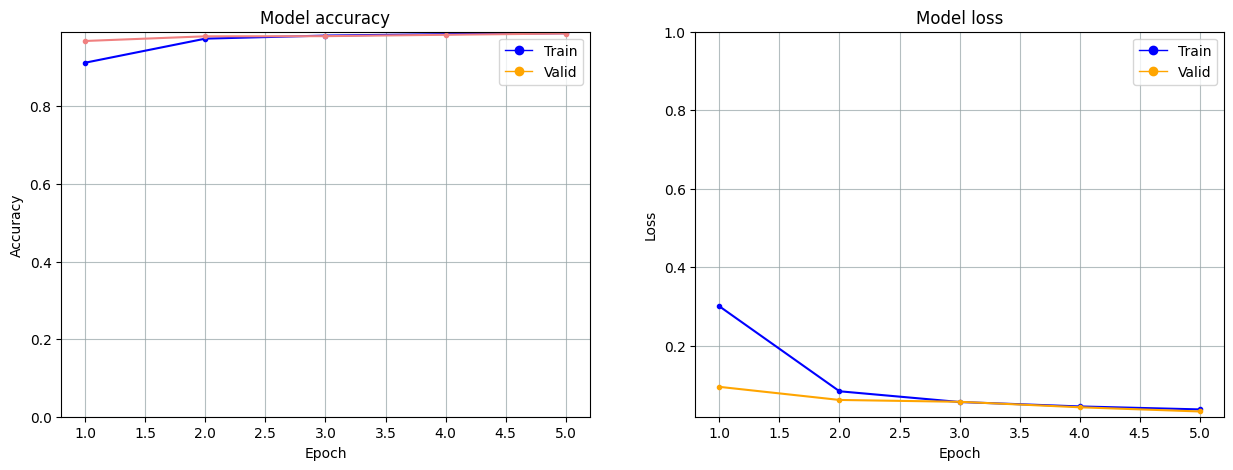

In [93]:
model = build_CNN(x_train[0].shape)
t0 = time()
hist = model.fit(x_train, y_train,
                 epochs=5,      # the total number of successive trainings
                 batch_size=128,  # fragmentation of the whole dada set in batches
                 validation_data=(x_valid, y_valid))
t = int(time()-t0)
h = int(t//3600)
m = int((t - h*3600)//60)
s = int((t - h*3600 -m*60))
print(f"\tTraining elapsed time {t}: {h:02d}h {m:02d}m {s:02d}s")

plot_loss_accuracy(hist, min_acc=0., max_loss=1, single_color=False)   

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8120 - loss: 0.6474 - val_accuracy: 0.9734 - val_loss: 0.0934
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9727 - loss: 0.0895 - val_accuracy: 0.9832 - val_loss: 0.0551
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9802 - loss: 0.0645 - val_accuracy: 0.9854 - val_loss: 0.0429
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9855 - loss: 0.0462 - val_accuracy: 0.9888 - val_loss: 0.0353
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9878 - loss: 0.0366 - val_accuracy: 0.9866 - val_loss: 0.0370
	Training elapsed time 6: 00h 00m 06s


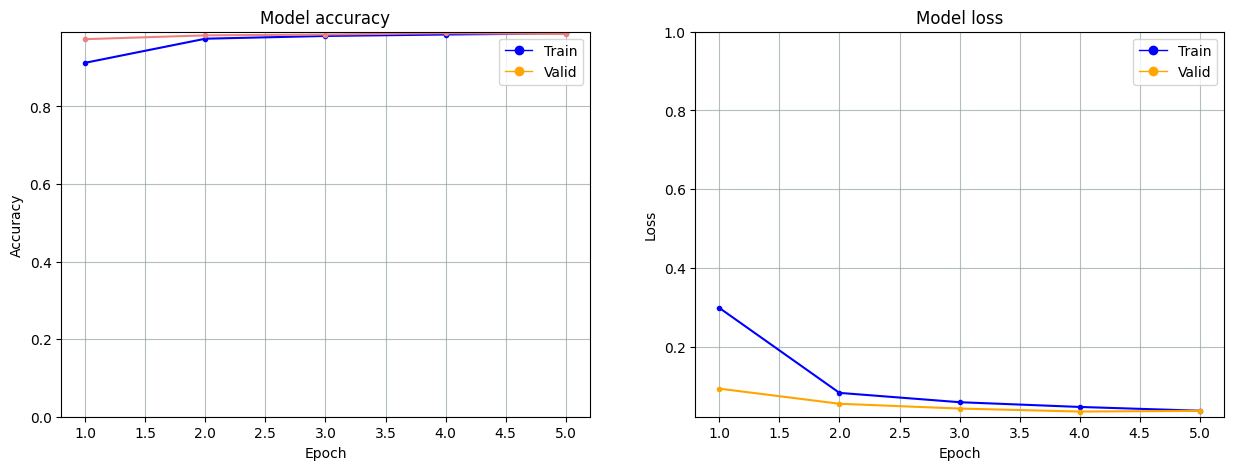

In [89]:
model = build_CNN(x_train[0].shape)
t0 = time()
hist = model.fit(x_train, y_train,
                 epochs=5,      # the total number of successive trainings
                 batch_size=128,  # fragmentation of the whole dada set in batches
                 validation_data=(x_valid, y_valid))
t = int(time()-t0)
h = int(t//3600)
m = int((t - h*3600)//60)
s = int((t - h*3600 -m*60))
print(f"\tTraining elapsed time {t}: {h:02d}h {m:02d}m {s:02d}s")

plot_loss_accuracy(hist, min_acc=0., max_loss=1, single_color=False)   

	Training elapsed time 5: 00h 00m 05s


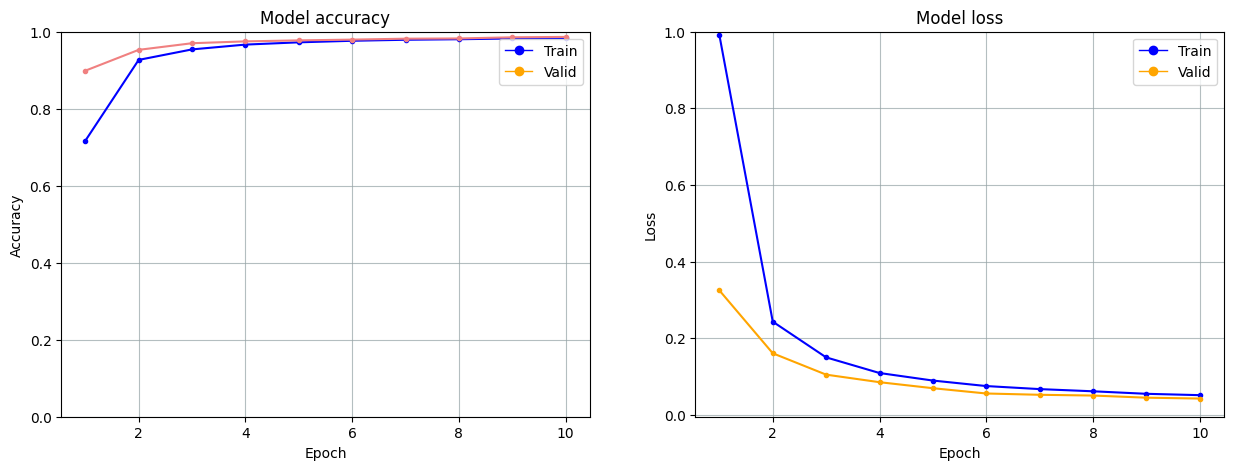

In [94]:
model = build_CNN(x_train[0].shape)
t0 = time()
hist = model.fit(x_train, y_train,
                 epochs=10,      # the total number of successive trainings
                 batch_size=1024,  # fragmentation of the whole dada set in batches
                 validation_data=(x_valid, y_valid), verbose=0)
t = int(time()-t0)
h = int(t//3600)
m = int((t - h*3600)//60)
s = int((t - h*3600 -m*60))
print(f"\tTraining elapsed time {t}: {h:02d}h {m:02d}m {s:02d}s")

plot_loss_accuracy(hist, min_acc=0., max_loss=1, single_color=False)   

	Training elapsed time 14: 00h 00m 14s


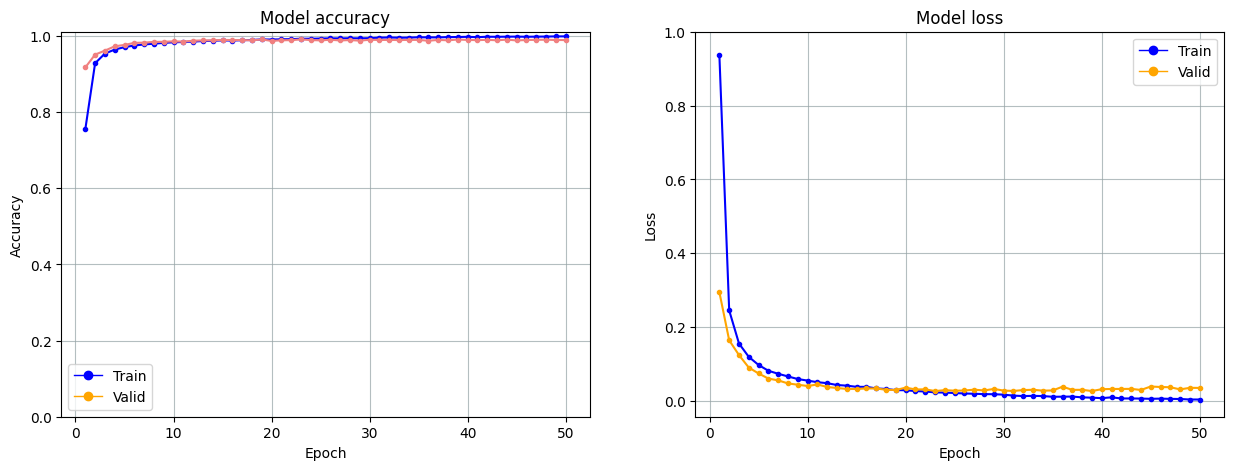

In [95]:
model = build_CNN(x_train[0].shape)
t0 = time()
hist = model.fit(x_train, y_train,
                 epochs=50,      # the total number of successive trainings
                 batch_size=1024,  # fragmentation of the whole dada set in batches
                 validation_data=(x_valid, y_valid), verbose=0)
t = int(time()-t0)
h = int(t//3600)
m = int((t - h*3600)//60)
s = int((t - h*3600 -m*60))
print(f"\tTraining elapsed time {t}: {h:02d}h {m:02d}m {s:02d}s")

plot_loss_accuracy(hist, min_acc=0., max_loss=1, single_color=False)   

	Training elapsed time 18: 00h 00m 18s


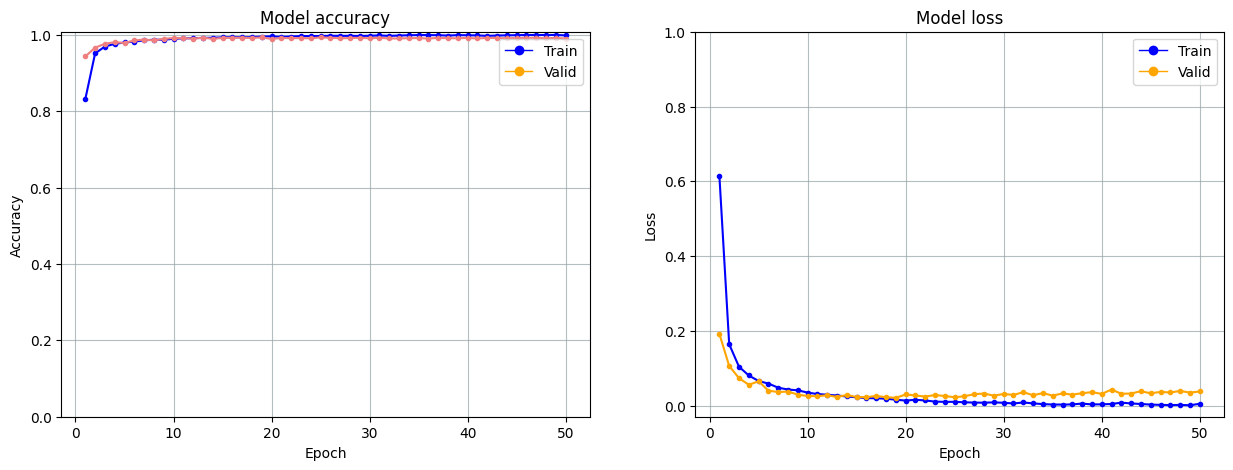

In [96]:
model = build_CNN(x_train[0].shape)
t0 = time()
hist = model.fit(x_train, y_train,
                 epochs=50,      # the total number of successive trainings
                 batch_size=512,  # fragmentation of the whole dada set in batches
                 validation_data=(x_valid, y_valid), verbose=0)
t = int(time()-t0)
h = int(t//3600)
m = int((t - h*3600)//60)
s = int((t - h*3600 -m*60))
print(f"\tTraining elapsed time {t}: {h:02d}h {m:02d}m {s:02d}s")

plot_loss_accuracy(hist, min_acc=0., max_loss=1, single_color=False)   

	Training elapsed time 24: 00h 00m 24s


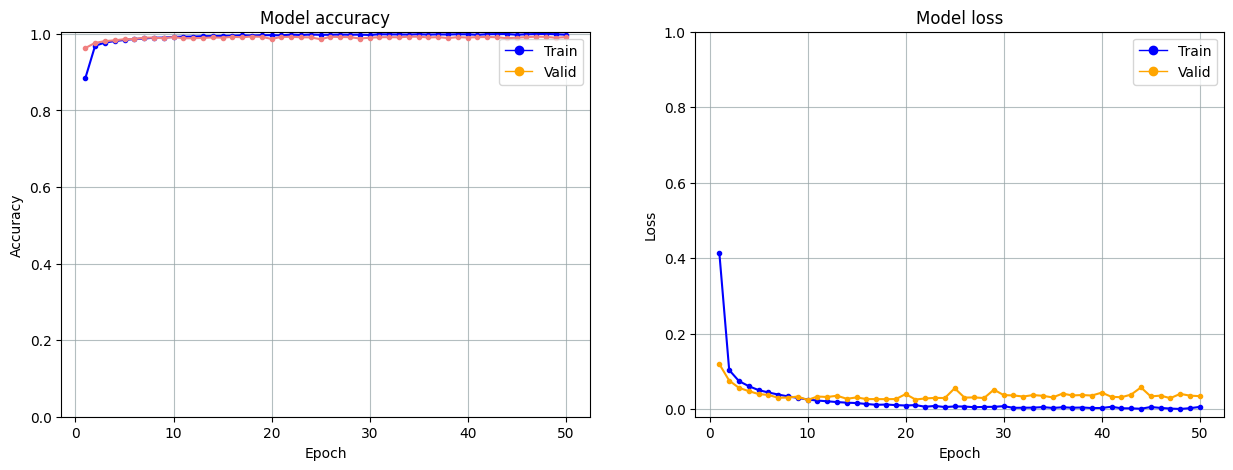

In [97]:
model = build_CNN(x_train[0].shape)
t0 = time()
hist = model.fit(x_train, y_train,
                 epochs=50,      # the total number of successive trainings
                 batch_size=256,  # fragmentation of the whole dada set in batches
                 validation_data=(x_valid, y_valid), verbose=0)
t = int(time()-t0)
h = int(t//3600)
m = int((t - h*3600)//60)
s = int((t - h*3600 -m*60))
print(f"\tTraining elapsed time {t}: {h:02d}h {m:02d}m {s:02d}s")

plot_loss_accuracy(hist, min_acc=0., max_loss=1, single_color=False)   

	Training elapsed time 35: 00h 00m 35s


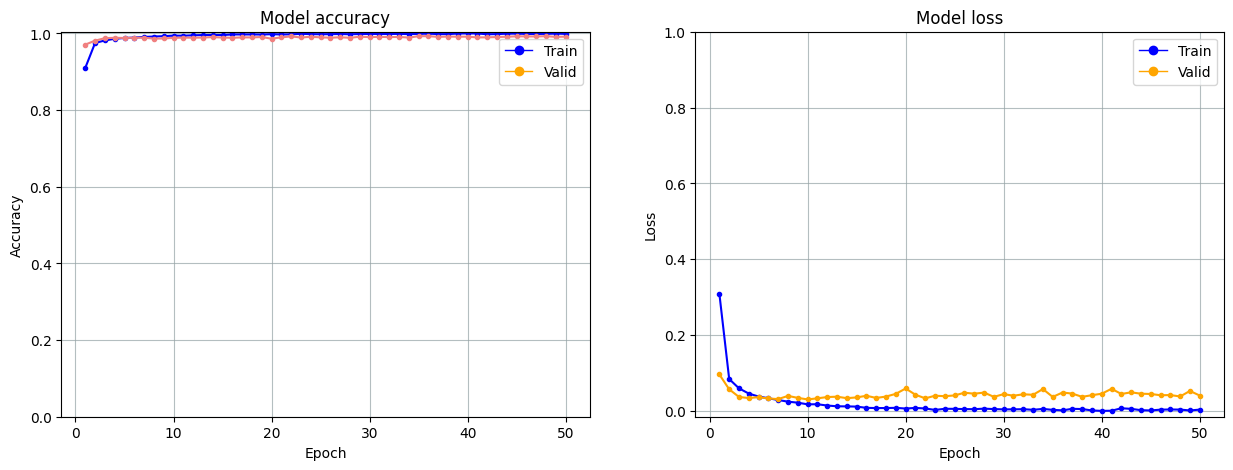

In [98]:
model = build_CNN(x_train[0].shape)
t0 = time()
hist = model.fit(x_train, y_train,
                 epochs=50,      # the total number of successive trainings
                 batch_size=128,  # fragmentation of the whole dada set in batches
                 validation_data=(x_valid, y_valid), verbose=0)
t = int(time()-t0)
h = int(t//3600)
m = int((t - h*3600)//60)
s = int((t - h*3600 -m*60))
print(f"\tTraining elapsed time {t}: {h:02d}h {m:02d}m {s:02d}s")

plot_loss_accuracy(hist, min_acc=0., max_loss=1, single_color=False)   

	Training elapsed time 67: 00h 01m 07s


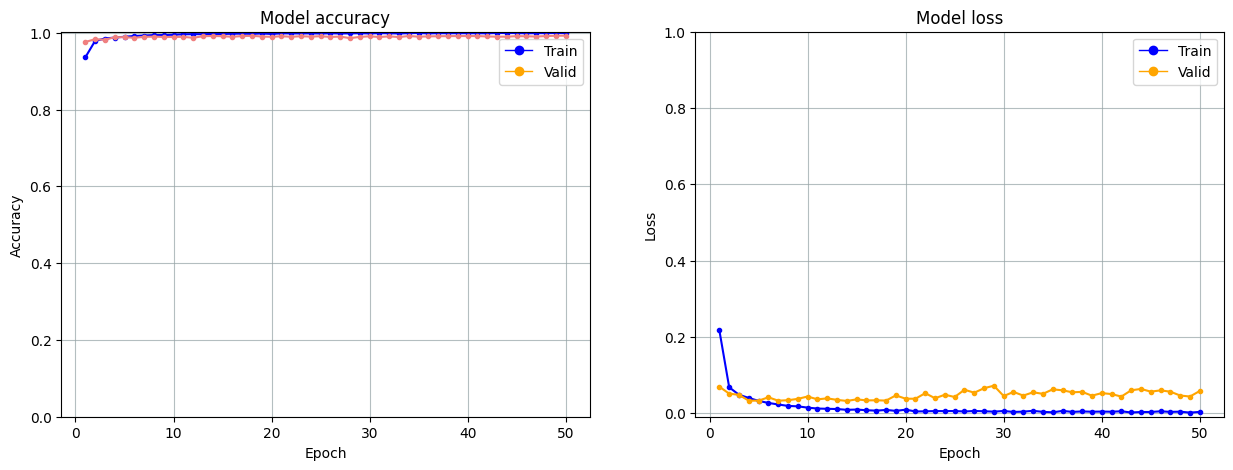

In [99]:
model = build_CNN(x_train[0].shape)
t0 = time()
hist = model.fit(x_train, y_train,
                 epochs=50,      # the total number of successive trainings
                 batch_size=64,  # fragmentation of the whole dada set in batches
                 validation_data=(x_valid, y_valid), verbose=0)
t = int(time()-t0)
h = int(t//3600)
m = int((t - h*3600)//60)
s = int((t - h*3600 -m*60))
print(f"\tTraining elapsed time {t}: {h:02d}h {m:02d}m {s:02d}s")

plot_loss_accuracy(hist, min_acc=0., max_loss=1, single_color=False)   

I0000 00:00:1741267867.010068  332242 service.cc:145] XLA service 0x79966c006dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741267867.010094  332242 service.cc:153]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
I0000 00:00:1741267868.071657  332242 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


	Training elapsed time 21: 00h 00m 21s


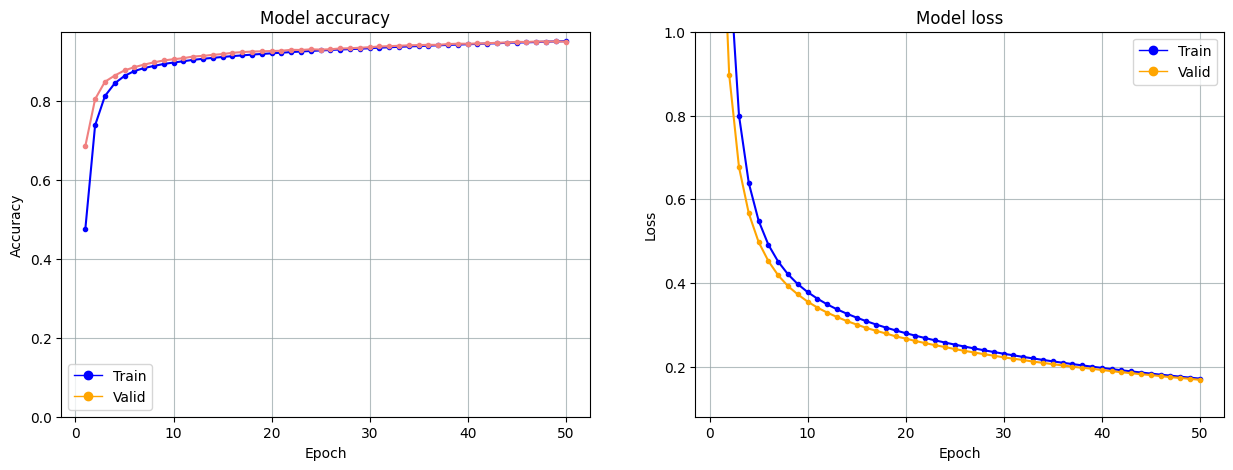

In [19]:
model = build_CNN(x_train[0].shape)
t0 = time()
hist = model.fit(x_train, y_train,
                 epochs=50,      # the total number of successive trainings
                 batch_size=1024,  # fragmentation of the whole dada set in batches
                 validation_data=(x_valid, y_valid), verbose=0)
t = int(time()-t0)
h = int(t//3600)
m = int((t - h*3600)//60)
s = int((t - h*3600 -m*60))
print(f"\tTraining elapsed time {t}: {h:02d}h {m:02d}m {s:02d}s")

plot_loss_accuracy(hist, min_acc=0., max_loss=1, single_color=False)   

In [21]:
model = build_CNN(x_train[0].shape)
t0 = time()
hist = model.fit(x_train, y_train,
                 epochs=50,      # the total number of successive trainings
                 batch_size=256,  # fragmentation of the whole dada set in batches
                 validation_data=(x_valid, y_valid), verbose=0)
t = int(time()-t0)
h = int(t//3600)
m = int((t - h*3600)//60)
s = int((t - h*3600 -m*60))
print(f"\tTraining elapsed time {t}: {h:02d}h {m:02d}m {s:02d}s")

	Training elapsed time 31: 00h 00m 31s


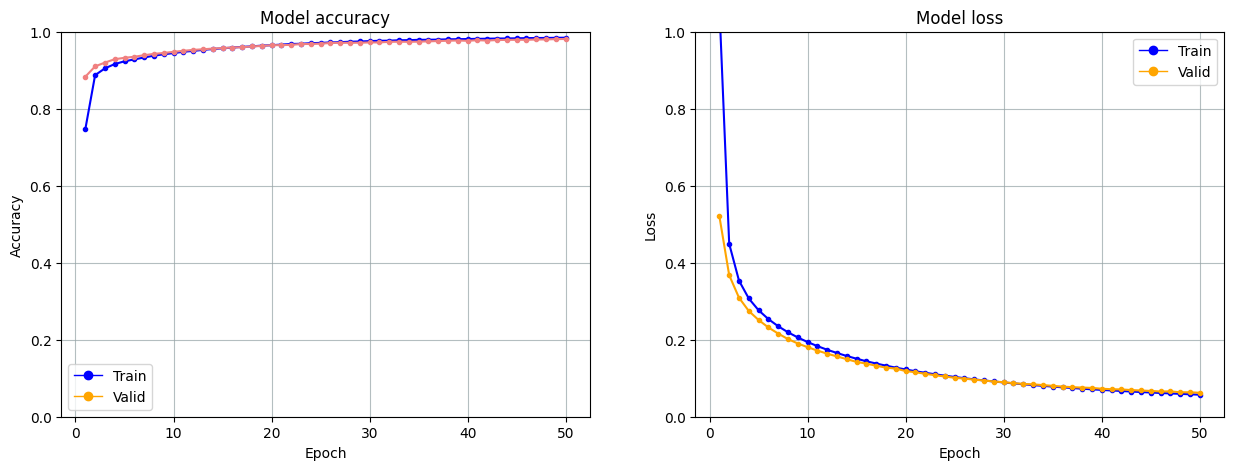

In [22]:
plot_loss_accuracy(hist, min_acc=0., max_acc=1, min_loss=0, max_loss=1, single_color=False)   

In [102]:
def elapsed_time_from(t0):
    t = int(time()-t0)
    h = int(t//3600)
    m = int((t - h*3600)//60)
    s = int((t - h*3600 -m*60))
    return f"\tElapsed time {t}s -> {h:02d}:{m:02d}:{s:02d}"

training  #1	Training elapsed time 55: 00h 00m 55s
	Training elapsed time 55: 00h 00m 55s
	Training elapsed time 55: 00h 00m 55s
	Training elapsed time 55: 00h 00m 55s
	Training elapsed time 54: 00h 00m 54s
	Training elapsed time 53: 00h 00m 53s
	Training elapsed time 53: 00h 00m 53s
	Training elapsed time 53: 00h 00m 53s
	Training elapsed time 55: 00h 00m 55s
	Training elapsed time 55: 00h 00m 55s


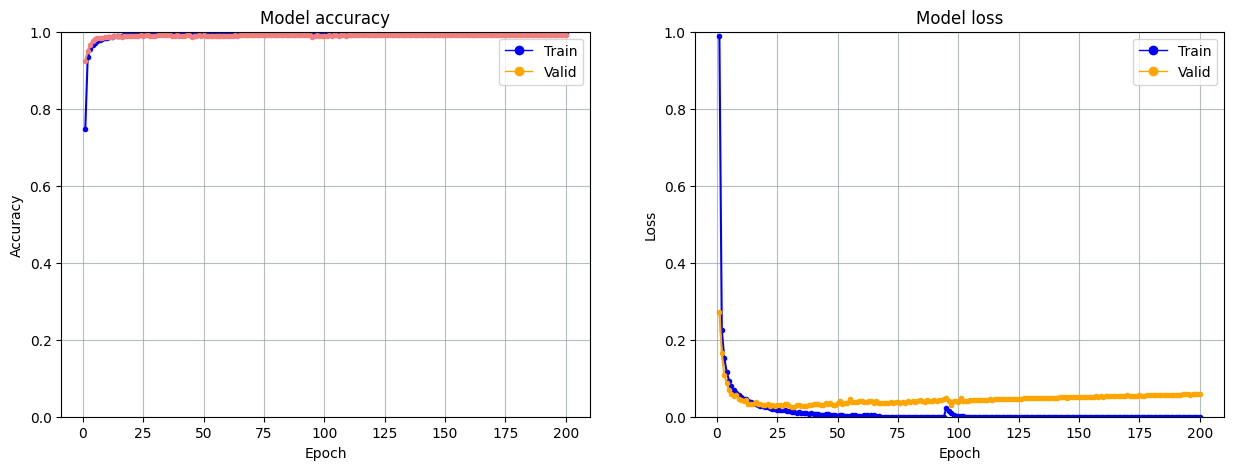

In [100]:
from time import time

H = []
print("training ", end="")

for i in range(10):
    print(f" #{i+1}", end="")
    
    # Build a new model at each lopp lap, without setting the tf seed:
    model = build_CNN(x_train[0].shape)
    
    # load the network structure & initial weights:
    # model = tf.keras.models.load_model(model_path)
    
    # Deterministic tensorflow training: 
    # see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html
    #tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf
    #tf.config.experimental.enable_op_determinism() 

    t0 = time()
    hist = model.fit(x_train, y_train,
                     epochs=200,      # the total number of successive trainings
                     batch_size=1024,  # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), verbose=0)
    
    t = int(time()-t0)
    h = int(t//3600)
    m = int((t - h*3600)//60)
    s = int((t - h*3600 -m*60))
    print(f"\tTraining elapsed time {t}: {h:02d}h {m:02d}m {s:02d}s")

    H.append(hist)  
    
plot_loss_accuracy(hist, min_acc=0., max_acc=1, min_loss=0, max_loss=1, single_color=False)   

training  #1	Training elapsed time 45: 00h 00m 45s
	Training elapsed time 48: 00h 00m 48s
	Training elapsed time 50: 00h 00m 50s
	Training elapsed time 47: 00h 00m 47s
	Training elapsed time 47: 00h 00m 47s
	Training elapsed time 47: 00h 00m 47s
	Training elapsed time 46: 00h 00m 46s
	Training elapsed time 46: 00h 00m 46s
	Training elapsed time 46: 00h 00m 46s
	Training elapsed time 46: 00h 00m 46s


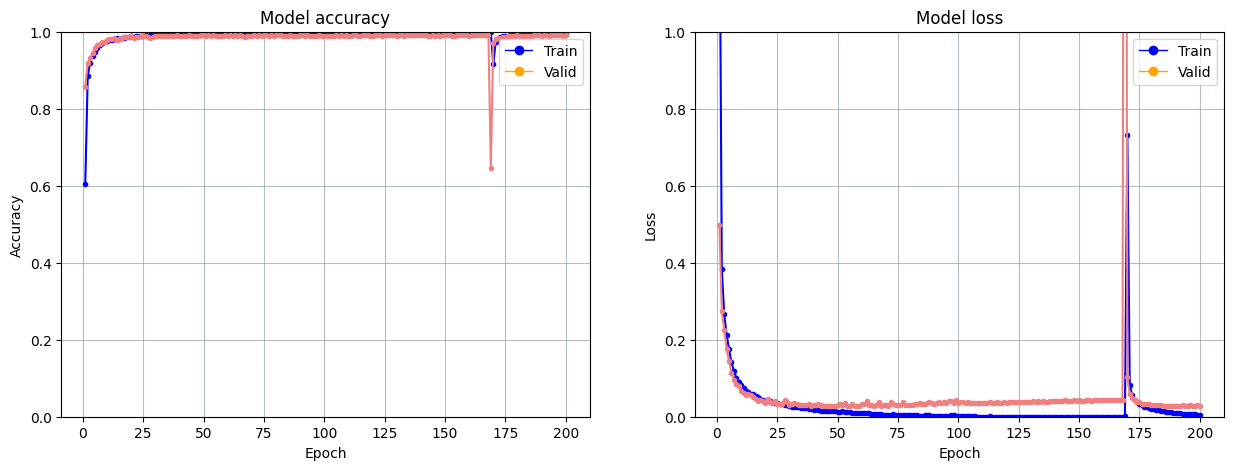

In [144]:
from time import time

H = []
print("training ", end="")

for i in range(10):
    print(f" #{i+1}", end="")
    
    # Build a new model at each lopp lap, without setting the tf seed:
    model = build_CNN(x_train[0].shape)
    
    # load the network structure & initial weights:
    # model = tf.keras.models.load_model(model_path)
    
    # Deterministic tensorflow training: 
    # see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html
    #tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf
    #tf.config.experimental.enable_op_determinism() 

    t0 = time()
    hist = model.fit(x_train, y_train,
                     epochs=200,      # the total number of successive trainings
                     batch_size=2048,  # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), verbose=0)
    
    t = int(time()-t0)
    h = int(t//3600)
    m = int((t - h*3600)//60)
    s = int((t - h*3600 -m*60))
    print(f"\tTraining elapsed time {t}: {h:02d}h {m:02d}m {s:02d}s")

    H.append(hist)  
    
plot_loss_accuracy(hist, min_acc=0., max_acc=1, min_loss=0, max_loss=1, single_color=False)   

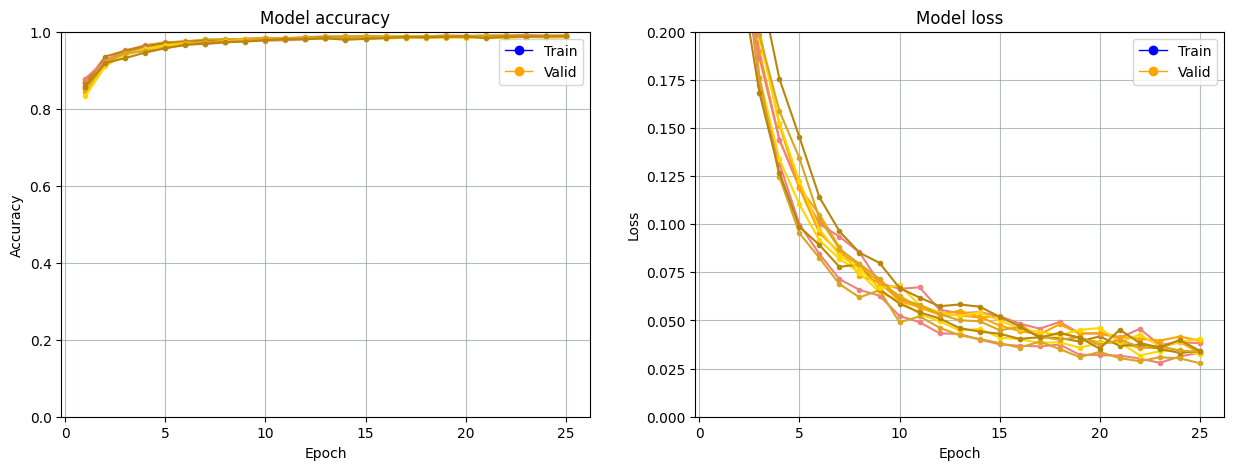

In [145]:
plot_loss_accuracy(H, training=False, min_acc=0., single_color=False, max_acc=1, min_loss=0, max_loss=.2,  max_epoch=25)   

training  #1	Training elapsed time 221: 00h 03m 41s
	Training elapsed time 221: 00h 03m 41s
	Training elapsed time 221: 00h 03m 41s
	Training elapsed time 223: 00h 03m 43s
	Training elapsed time 222: 00h 03m 42s
	Training elapsed time 222: 00h 03m 42s
	Training elapsed time 221: 00h 03m 41s
	Training elapsed time 220: 00h 03m 40s
	Training elapsed time 220: 00h 03m 40s
	Training elapsed time 221: 00h 03m 41s


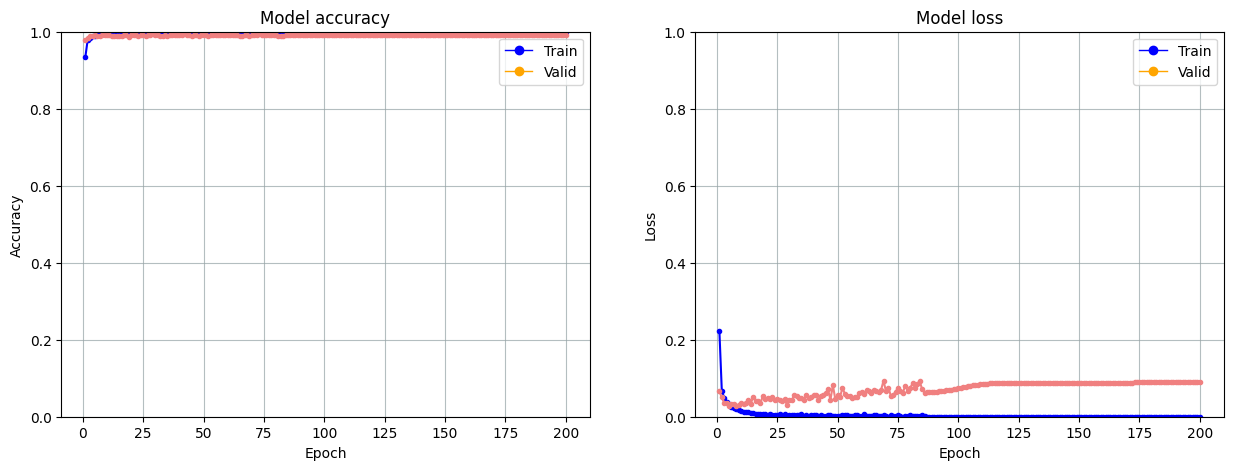

In [147]:
from time import time

H = []
print("training ", end="")

for i in range(10):
    print(f" #{i+1}", end="")
    
    # Build a new model at each lopp lap, without setting the tf seed:
    model = build_CNN(x_train[0].shape)
    
    # load the network structure & initial weights:
    # model = tf.keras.models.load_model(model_path)
    
    # Deterministic tensorflow training: 
    # see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html
    #tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf
    #tf.config.experimental.enable_op_determinism() 

    t0 = time()
    hist = model.fit(x_train, y_train,
                     epochs=200,      # the total number of successive trainings
                     batch_size=64,  # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), verbose=0)
    
    t = int(time()-t0)
    h = int(t//3600)
    m = int((t - h*3600)//60)
    s = int((t - h*3600 -m*60))
    print(f"\tTraining elapsed time {t}: {h:02d}h {m:02d}m {s:02d}s")

    H.append(hist)  
    
plot_loss_accuracy(hist, min_acc=0., max_acc=1, min_loss=0, max_loss=1, single_color=False)   

training  #1	Training elapsed time 103: 00h 01m 43s
	Training elapsed time 103: 00h 01m 43s
	Training elapsed time 105: 00h 01m 45s
	Training elapsed time 107: 00h 01m 47s
	Training elapsed time 115: 00h 01m 55s
	Training elapsed time 112: 00h 01m 52s
	Training elapsed time 105: 00h 01m 45s
	Training elapsed time 107: 00h 01m 47s
	Training elapsed time 113: 00h 01m 53s
	Training elapsed time 103: 00h 01m 43s


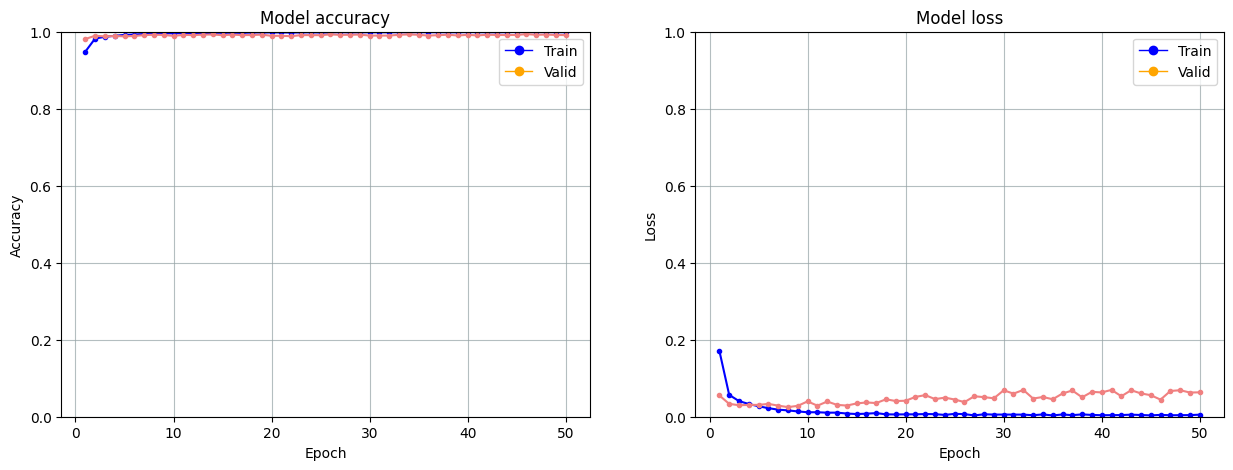

In [158]:
from time import time

H = []
print("training ", end="")

for i in range(10):
    print(f" #{i+1}", end="")
    
    # Build a new model at each lopp lap, without setting the tf seed:
    model = build_CNN(x_train[0].shape)
    
    # load the network structure & initial weights:
    # model = tf.keras.models.load_model(model_path)
    
    # Deterministic tensorflow training: 
    # see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html
    #tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf
    #tf.config.experimental.enable_op_determinism() 

    t0 = time()
    hist = model.fit(x_train, y_train,
                     epochs=50,      # the total number of successive trainings
                     batch_size=32,  # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), verbose=0)
    
    t = int(time()-t0)
    h = int(t//3600)
    m = int((t - h*3600)//60)
    s = int((t - h*3600 -m*60))
    print(f"\tTraining elapsed time {t}: {h:02d}h {m:02d}m {s:02d}s")

    H.append(hist)  
    
plot_loss_accuracy(hist, min_acc=0., max_acc=1, min_loss=0, max_loss=1, single_color=False)   

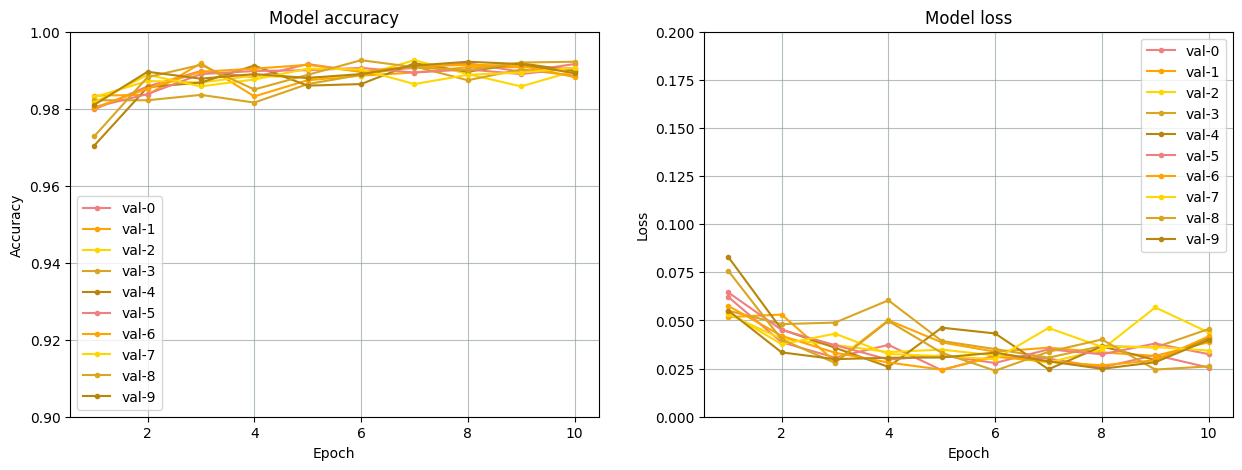

In [162]:
plot_loss_accuracy(H, min_acc=0.9, max_acc=1, min_loss=.0,max_loss=.2, training=False, single_legend=False, single_color=False, max_epoch=10)    

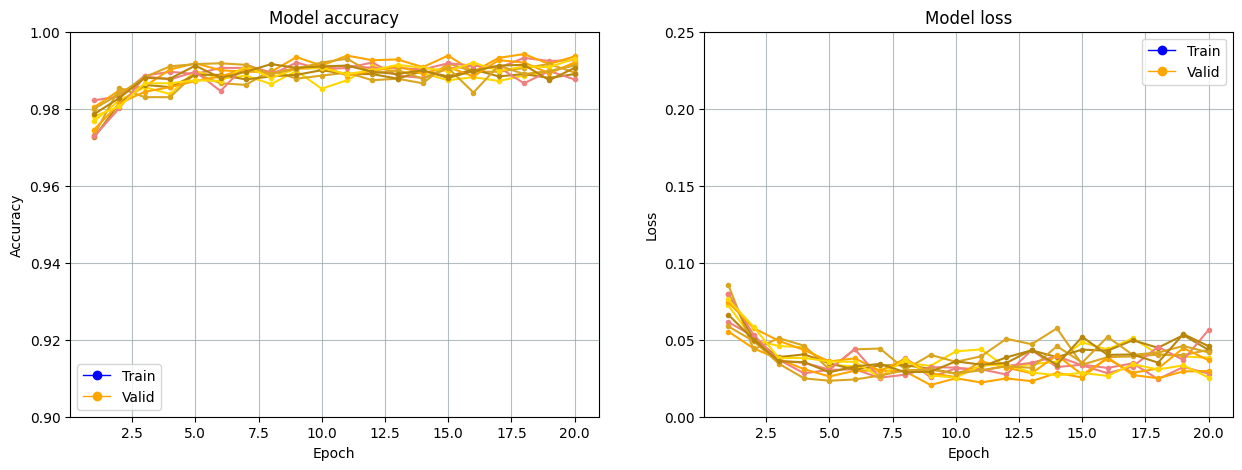

In [152]:
plot_loss_accuracy(H, min_acc=0.9, max_acc=1, min_loss=.0,max_loss=.25, training=False, single_color=False, max_epoch=20)    

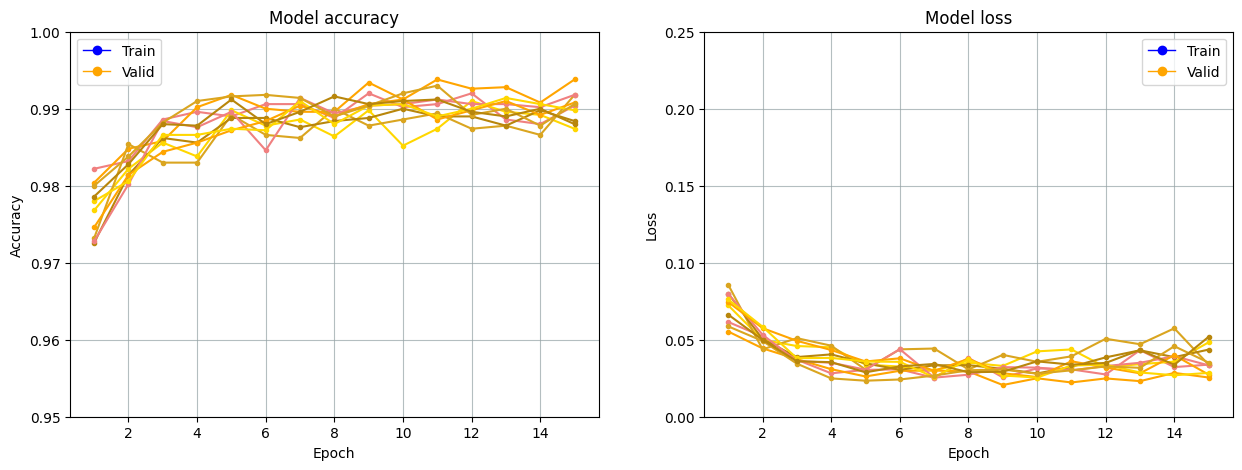

In [157]:
plot_loss_accuracy(H, min_acc=0.95, max_acc=1, min_loss=.0,max_loss=.25, training=False, single_color=False, max_epoch=15)    

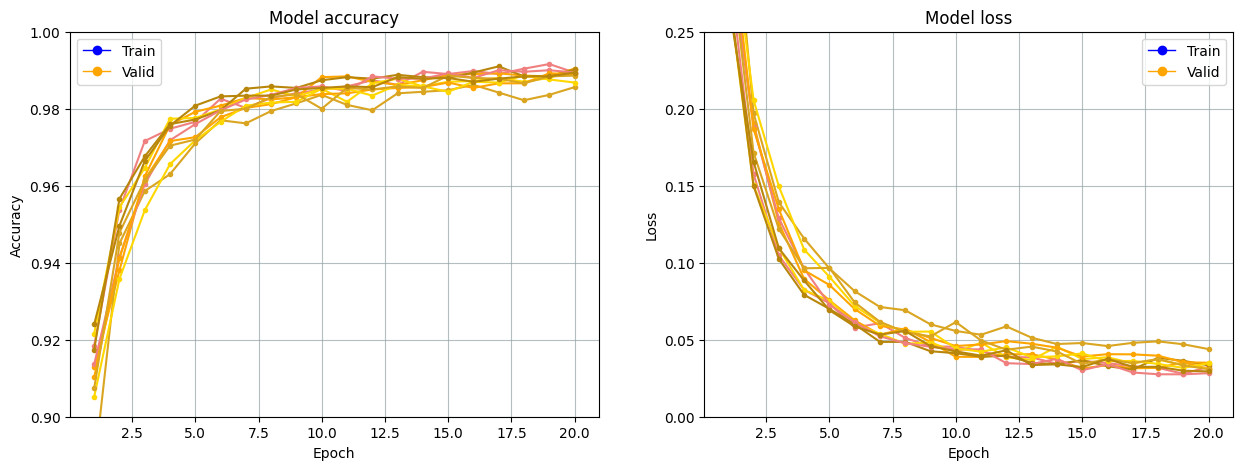

In [143]:
plot_loss_accuracy(H, min_acc=0.9, max_acc=1, min_loss=.0,max_loss=.5, training=False, single_color=False, max_epoch=20)    

In [66]:
x_test.shape, y_test.shape

((5000, 28, 28, 1), (5000, 10))

In [75]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# Predicting labels for test images
predict_labels = np.argmax(model.predict(x_test), axis=-1)

# Display classification report
print("Classification Report:\n", classification_report(np.argmax(y_test, axis=-1), predict_labels))

157/157 - 0s - 2ms/step - accuracy: 0.9890 - loss: 0.1324
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       490
           1       0.99      0.99      0.99       568
           2       0.99      0.99      0.99       516
           3       0.99      0.99      0.99       505
           4       0.99      0.99      0.99       491
           5       0.99      0.99      0.99       446
           6       0.99      0.99      0.99       479
           7       0.99      0.99      0.99       514
           8       0.98      0.99      0.98       487
           9       0.99      0.98      0.98       504

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



In [153]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# Predicting labels for test images
predict_labels = np.argmax(model.predict(x_test), axis=-1)

# Display classification report
print("Classification Report:\n", classification_report(np.argmax(y_test, axis=-1), predict_labels))

157/157 - 0s - 2ms/step - accuracy: 0.9906 - loss: 0.1321
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       490
           1       0.99      0.99      0.99       568
           2       0.99      0.98      0.99       516
           3       0.99      0.99      0.99       505
           4       0.99      0.99      0.99       491
           5       0.99      0.99      0.99       446
           6       0.99      0.98      0.99       479
           7       0.99      0.99      0.99       514
           8       0.99      1.00      0.99       487
           9       0.99      0.99      0.99       504

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



## 6/ Exploitation du réseau avec le jeu de test

La méthode `predict` de l'objet `model` permet de calculer les inférences du réseau pour une ou plusieurs entrées (voir la méthode `predict`dans la page [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)).

La cellule ci-dessous montre la mise en oeuvre de la méthode `predict`, et comment exploiter la représentation  *one-hot* renvoyée par `fit` en utilisant la méthode `argmax` des tableaux de numpy :

In [ ]:
from utils.tools import plot_images

i = 100   # numéro image de test
rep = model.predict(x_test[i:i+1]) # Attention: x doit être un tableau de matrices...
                                   # => x[i] ne convient pas !

print(f"sortie du réseau pour l'image de rang {i} :\n{rep[0]}")

# limiter l'affichage des composantes des tableaux numpy à 1 chiffre :    
with np.printoptions(formatter={'float':'{:.2f}'.format}):    
    print(f"\nsortie réseau arrondie à 2 chiffre : {rep[0]}")
    
print(f"rep[0].argmax() donne : {rep[0].argmax()}")

print(f"\nLa bonne réponse est {lab_test[i]} soit en 'one-hot' : {y_test[i]}")

plot_images(im_test,i,1,1)

#### Utilité de la méthode numpy `ndarray.argmax` pour décoder le tableau de vecteurs *one-hot* renvoyé par la méthode `predict`

Quand on calcule l'inférence du réseau `model` avec les données de test par exemple, on obtient un résultat qui est un tableau de vecteurs codés *one-hot*, comme le détaille la cellue suivante :

In [ ]:
results = model.predict(x_test)

print("forme du tableau 'results':", results.shape)
print("allure des vecteurs du tableau 'result', par exemple :")
with np.printoptions(formatter={'float':'{:.4f}'.format}): 
    print("results[0]  :", results[0])
    print("results[-1] :", results[-1])

En écrivant `results.argmax(axe=-1)`, on obtient le tableau des `argmax` de chaque vecteur -> c'est directement le tableau des chiffres reconnus par le réseau :

In [ ]:
chiffres_reconnus = results.argmax(axis=-1)

print("chiffres_reconnus -> shape:", chiffres_reconnus.shape, ", dtype:", chiffres_reconnus.dtype)
print(f"contenu de chiffres_reconnus : {chiffres_reconnus}")

Retrouver le taux de réussite du réseau entrainé en utilisant les inférences du réseau pour les entrées `x_test` et les labels `lab_test` :

In [ ]:
results = model.predict(x_test)
chiffres_reconnus = results.argmax(axis=-1)

success = 0
for chiffre, label in zip(chiffres_reconnus, lab_test):
    success += (chiffre == label)
print(f"taux de réussite : {success/len(x_test)*100:.2f} %")

###  Afficher la matrice de confusion

La cellule suivante définie la fonction `show_cm_mnist` qui affiche la **matrice de confusion**.

La matrice de confusion permet de visualiser :
- sur la diagonale : les bonnes réponses du réseau, avec dans chaque case le nombre de bonnes réponses
- hors diagonale : les erreurs du réseau, avec dans chaque case la fréquence d'apparition de l'erreur.

In [ ]:
import pandas as pd
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

def show_cm_mnist(target, results, classes):
    # target  : the actual labels (one-hot format)
    # results : the labels computed by the trained network (one-hot format)
    # classes : list of possible label values
    predicted = np.argmax(results, axis=-1) # tableau d'entiers entre 0 et 9 
    cm = confusion_matrix(target, predicted)
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(11,9))
    heatmap(df_cm, annot=True, cbar=False, fmt="3d")
    plt.xlabel('actual label')
    plt.ylabel('predicted label')
    plt.show()

Faire afficher la matrice de confusion en lui passant les labels attendus `lab_test` et les labels calculés par le model :

In [ ]:
show_cm_mnist(lab_test, results, range(nb_classe))

Effectivement, il y a assez peu d'erreurs hors diagonale.

# Autres ressources intéressantes... des vidéos :

In [1]:
%%HTML
<iframe src="https://www.youtube.com/embed/trWrEWfhTVg" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [2]:
%%HTML
<iframe src="https://www.youtube.com/embed/aircAruvnKk" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [3]:
%%HTML
<iframe src="https://www.youtube.com/embed/IHZwWFHWa-w" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [4]:
%%HTML
<iframe src="https://www.youtube.com/embed/Ilg3gGewQ5U" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [136]:
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_loss_accuracy(hist:list, 
                       max_epoch = None,
                       min_acc=None,  max_acc=None, 
                       min_loss=None, max_loss=None, 
                       training=True, 
                       single_color:bool = True, 
                       single_legend:bool=True):
    '''
    Plot training & validation loss & accuracy values, giving an argument
    'hist' of type 'tensorflow.python.keras.callbacks.History'. 
    '''
    
    custom_lines = [Line2D([0], [0], color='blue', lw=1, marker='o'),
                    Line2D([0], [0], color='orange', lw=1, marker='o')]
    val_colors = ('lightcoral', 'orange', 'gold', 'goldenrod', 'darkgoldenrod')
    
    plt.figure(figsize=(15,5))
    
    if not isinstance(hist, list): hist = [hist]

    if max_epoch is None:
        epoch_array = np.array(hist[0].epoch)+1
    else:
        epoch_array = np.arange(1, max_epoch+1)
    nb_epoch = len(epoch_array)
    
    ax1 = plt.subplot(1,2,1)
    for (i, h) in enumerate(hist):
        if h.history.get('accuracy') and training:
            ax1.plot(epoch_array, h.history['accuracy'][:nb_epoch], 'o-', 
                     markersize=3,
                     color='blue', label=f'train-{i:01d}')
        if h.history.get('val_accuracy'):
            if single_color:
                val_color = 'orange'
            else:
                val_color = val_colors[i % len(val_colors)]
            ax1.plot(epoch_array, h.history['val_accuracy'][:nb_epoch], 'o-', 
                     markersize=3,
                     color=val_color, label=f'val-{i:01d}')
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch') 
    y_min, y_max = ax1.get_ylim()
    y_min = y_min if min_acc is None else min_acc
    y_max = y_max if max_acc is None else max_acc
    ax1.set_ylim((y_min, y_max))
    ax1.grid(which='major', color='xkcd:cool grey',  linestyle='-',  alpha=0.7)
    ax1.grid(which='minor', color='xkcd:light grey', linestyle='--', alpha=0.5)
    if  single_legend:
        ax1.legend(custom_lines, ['Train', 'Valid'])
    else:
        ax1.legend()
    #ax1.set_xticks(np.arange(1, len(h.epoch)+1))
    
    
    # Plot training & validation loss values
    ax2 = plt.subplot(1,2,2)
    for (i, h) in enumerate(hist):
        if h.history.get('loss') and training:
            ax2.plot(epoch_array, h.history['loss'][:nb_epoch], 'o-',  
                     markersize=3,
                     color='blue', label=f'train-{i:01d}')
        if h.history.get('val_loss'):
            if single_color:
                val_color = 'orange'
            else:
                val_color = val_colors[i % len(val_colors)]
            ax2.plot(epoch_array, h.history['val_loss'][:nb_epoch], 'o-', 
                     markersize=3,
                     color=val_color, label=f'val-{i:01d}')
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    y_min, y_max = ax2.get_ylim()
    y_min = y_min if min_loss is None else min_loss
    y_max = y_max if max_loss is None else max_loss
    ax2.set_ylim((y_min, y_max))
    ax2.grid(which='major', color='xkcd:cool grey',  linestyle='-',  alpha=0.7)
    ax2.grid(which='minor', color='xkcd:light grey', linestyle='--', alpha=0.5)
    if  single_legend:
        ax2.legend(custom_lines, ['Train', 'Valid'])
    else:
        ax2.legend()
    #ax2.set_xticks(np.arange(1, len(h.epoch)+1))

    plt.show()
